# Orfeus Workshop 2022 (Potsdam)

This notebook contains simplified workflow for web services exposed by the EIDA (European Integrated Data Archive) Federation, focused on the EIDAWS-WFCatalog service and its functionalities allowing users to filter out low quality and low coverage data before downloading it to the local machine.

In this example we are going to:

1. Retrieve seismic event information from FDSNWS-Event catalogue offered by [GFZ](https://www.gfz-potsdam.de/) EIDA Node:
    * Date:
        * 📅 start date = 2020-01-01
        * 📅 end date = 2020-06-01
    * Event characteristics:
        * 🎚️ minimum magnitude = 5
    * Coordinates:
        * 🌐 minimum latitude = 40°N
        * 🌐 maximum latitude = 45°N
        * 🌐 minimum longitude = 17°E
        * 🌐 maximum longitude = 25°E
1. Using [FDSNWS-Station](https://www.orfeus-eu.org/data/eida/webservices/station/) web service, list all stations available in the region defined using epicentral distance.
1. Using [EIDAWS-WFCatalog](https://www.orfeus-eu.org/data/eida/webservices/wfcatalog/) service, exclude all stations which do not meet following criteria:
    * At least 95% data coverage on the day of the event
    * Maximum of 5 gaps
    * Sum of gaps lower than 50 seconds
    * No overlaps
1. Using [FDSNWS-Dataselect](https://www.orfeus-eu.org/data/eida/webservices/dataselect/) web service, download miniSEED files containing the waveforms from a time window defined using theoretial seismic wave arrival times.

## Imports

In [39]:
import requests
import json
import pprint
from datetime import datetime, timedelta
from obspy import UTCDateTime
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn import RoutingClient
from obspy.taup import TauPyModel

## Config

In [40]:
# Define start and end dates for the event search
START = "2020-01-01"
END = "2020-06-01"

# Define event minimum magnitude and bounding box for event search
MAG_MIN = 5
LAT_MIN = 40
LAT_MAX = 45
LON_MIN = 17
LON_MAX = 25

# Max radius of stations from the epicenter (degrees)
RADIUS_MAX = 2

# Encoding for the HTTP requests
ENCODING = "utf-8"

# WFCatalog filter
AVAILABILITY_MIN = 95
GAPS_MAX = 5
GAPS_SUM_MAX = 50
OVERLAPS_MAX = 0

In [41]:
# Global instances
CLIENT_GFZ = Client("GFZ")
CLIENT_EIDA = RoutingClient("eida-routing")

# We use the iasp91 reference model
TAUP_MODEL = TauPyModel(model="iasp91")

## Getting the event catalog

In [42]:
catalog = CLIENT_GFZ.get_events(
    starttime=START,
    endtime=END,
    minmagnitude=MAG_MIN,
    minlatitude=LAT_MIN,
    maxlatitude=LAT_MAX,
    minlongitude=LON_MIN,
    maxlongitude=LON_MAX,
)
event = catalog[0]
print(event)

Event:	2020-01-28T20:15:10.670000Z | +41.433,  +19.569 | 5.06 mb | automatic

	            resource_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/gfz2020bywr")
	          creation_info: CreationInfo(agency_id='GFZ', creation_time=UTCDateTime(2020, 1, 28, 20, 16, 31, 618036))
	    preferred_origin_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20200128202144.356462.2018953/netMag/mb")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


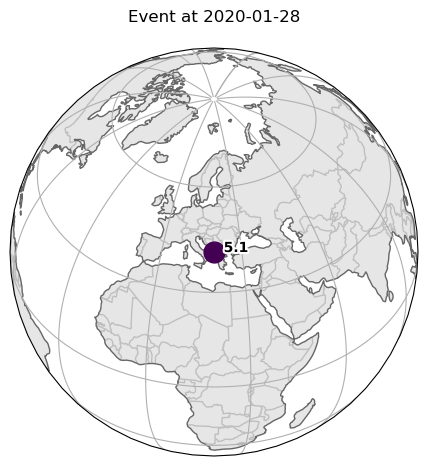

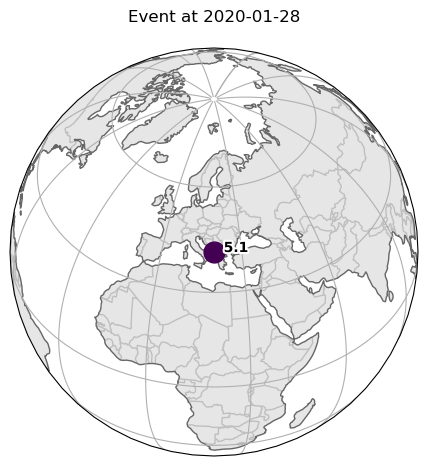

In [43]:
catalog.plot(projection="ortho")

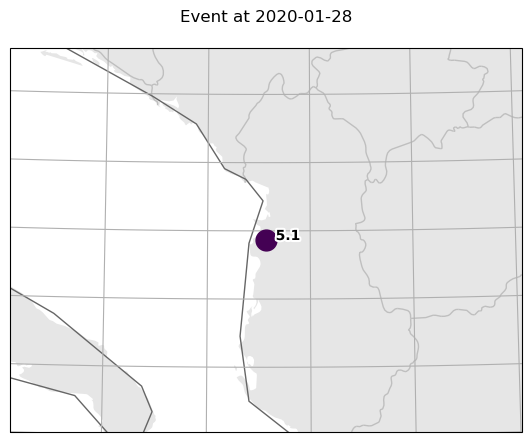

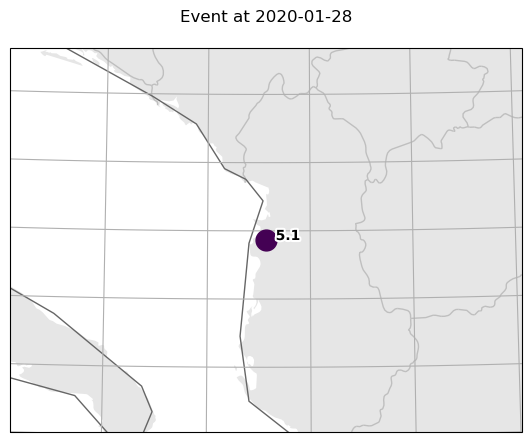

In [44]:
catalog.plot(projection="local")

## Getting the station inventory

In [45]:
inventory = CLIENT_EIDA.get_stations(
    startbefore=event.origins[0].time,
    endafter=event.origins[0].time,
    latitude=event.origins[0].latitude,
    longitude=event.origins[0].longitude,
    maxradius=RADIUS_MAX,
)
print(inventory)

Inventory created at 2022-09-28T14:42:56.520954Z
	Created by: ObsPy 1.3.0
		    https://www.obspy.org
	Sending institution: ObsPy FDSN Routing 1.3.0,SeisNet-mysql (INGV-CNT)
	Contains:
		Networks (3):
			AC, IV, MN
		Stations (12):
			AC.BCI (Bajram Curri, Albania)
			AC.KBN (Korce, Albania)
			AC.LSK (Leskovik, Albania)
			AC.PHP (Peshkopi, Albania)
			AC.PUK (Puke, Albania)
			AC.SRN (Sarande, Albania)
			AC.VLO (Vlore, Albania)
			IV.MESG (Mesagne)
			IV.SCTE (Santa Cesarea Terme)
			MN.KEK (Kerkira Island, Greece)
			MN.PDG (Podgorica, Montenegro)
			MN.TIR (Tirana, Albania)
		Channels (0):



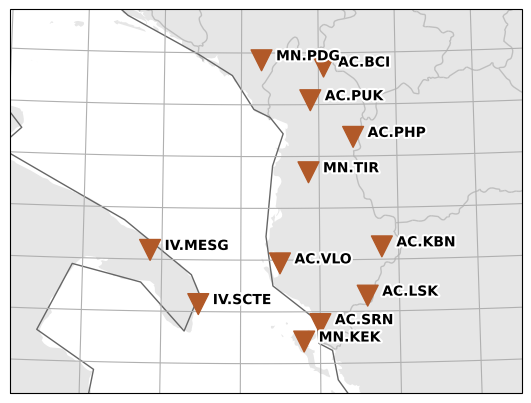

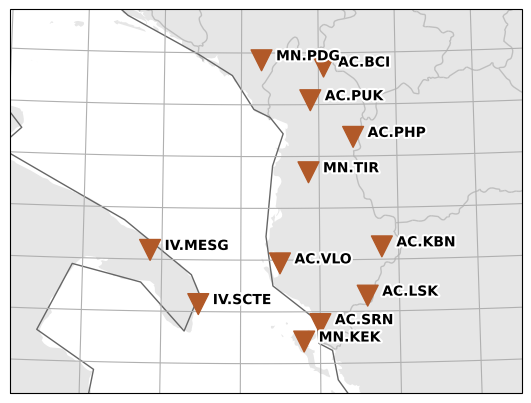

In [46]:
inventory.plot(projection="local")

## Validation function for the WFCatalog metrics

In [47]:
def validate_station(string):
    """Our validating function which takes WFCatalog response json and returns
    list of network/station/channels for which all components are
    present and validated against our criteria.

    Args:
        string (string): JSON response from EIDAWS-WFCatalog web service

    Returns:
        []: List of validated networks, stations and channels
        None: If no channels have been found, function returns `None`
    """
    # Define mandatory channels
    required_channels = {
        "BH?": ["BHE", "BHN", "BHZ"],
        # "HH?": ["HHE", "HHN", "HHZ"],
        # "LH?": ["LHE", "LHN", "LHZ"],
    }

    # Parse string to json object
    j = json.loads(string)

    # Define channels_found as set to allow only unique values
    channels_found = set()
    channels_validated = []

    for cha in j:
        # Get network station channel identifiers
        network_code = cha["network"]
        station_code = cha["station"]
        channel_code = cha["channel"]

        # Get the quality metrics
        availability = int(cha["percent_availability"])
        gaps = int(cha["num_gaps"])
        sum_gaps = int(cha["sum_gaps"])
        overlaps = int(cha["num_overlaps"])

        msg = f"{network_code}.{station_code}.{channel_code}: {availability}% coverage, {gaps} gaps ({sum_gaps}s), {overlaps} overlaps."
        if (
            availability < AVAILABILITY_MIN
            or gaps > GAPS_MAX
            or sum_gaps > GAPS_SUM_MAX
            or overlaps > OVERLAPS_MAX
        ):
            print(f"NOK: {msg}")
        else:
            print(f"OK: {msg}")
            channels_found.add(channel_code.upper())

    # If channel components are present and validated, add them to the channels_validated list
    for c in required_channels.keys():
        if all(e in channels_found for e in required_channels[c]):
            channels_validated.append(c)

    if len(channels_validated) > 0:
        return ",".join(channels_validated)
    else:
        return None

## Getting list of stations filtered using WFCatalog metrics

In [48]:
# List of verified stations, will be filled later
validated_stations = []

# Prepare from-to dates for the WFCatalog query
event_day = datetime(
    event.origins[0].time.year, event.origins[0].time.month, event.origins[0].time.day
)
event_day_next = event_day + timedelta(days=1)

for net in inventory.networks:
    for sta in net.stations:
        wfcatalog_url = "http://eida-federator.ethz.ch/eidaws/wfcatalog/1/query"

        query_params = {
            "start": event_day.isoformat(),
            "end": event_day_next.isoformat(),
            "network": net.code,
            "station": sta.code,
        }

        # Request the data...
        r = requests.get(wfcatalog_url, params=query_params, timeout=10)
        r.encoding = ENCODING

        if r.status_code == 200:
            # Validate station
            cha = validate_station(r.text)
            if cha:
                # Validation passed, add to verified_stations list
                validated_stations.append(
                    {
                        "network": net.code,
                        "station": sta.code,
                        "latitude": sta.latitude,
                        "longitude": sta.longitude,
                        "channels": cha,
                    }
                )
        else:
            pass

# Let's print our validated stations
pp = pprint.PrettyPrinter()
pp.pprint(validated_stations)

NOK: AC.KBN.HHE: 100% coverage, 0 gaps (0s), 1056 overlaps.
NOK: AC.KBN.HHN: 99% coverage, 1 gaps (2s), 1001 overlaps.
NOK: AC.KBN.HHZ: 100% coverage, 0 gaps (0s), 1065 overlaps.
NOK: AC.VLO.HHZ: 100% coverage, 0 gaps (0s), 197 overlaps.
NOK: AC.VLO.HHN: 100% coverage, 0 gaps (0s), 194 overlaps.
NOK: AC.VLO.HHE: 100% coverage, 0 gaps (0s), 221 overlaps.
OK: IV.MESG.HHE: 99% coverage, 3 gaps (3s), 0 overlaps.
OK: IV.MESG.BHZ: 99% coverage, 3 gaps (2s), 0 overlaps.
OK: IV.MESG.BHE: 99% coverage, 3 gaps (4s), 0 overlaps.
OK: IV.MESG.BHN: 99% coverage, 3 gaps (4s), 0 overlaps.
OK: IV.MESG.HHN: 99% coverage, 3 gaps (3s), 0 overlaps.
NOK: IV.MESG.HNZ: 99% coverage, 7 gaps (7s), 0 overlaps.
OK: IV.MESG.LHE: 99% coverage, 3 gaps (4s), 0 overlaps.
OK: IV.MESG.LHN: 99% coverage, 3 gaps (4s), 0 overlaps.
OK: IV.MESG.LHZ: 99% coverage, 3 gaps (3s), 0 overlaps.
OK: IV.MESG.HHZ: 99% coverage, 3 gaps (3s), 0 overlaps.
NOK: IV.MESG.HNE: 99% coverage, 7 gaps (10s), 0 overlaps.
NOK: IV.MESG.HNN: 99% cov

## Function calculating theoretical seismic wave arrival time at station

In [49]:
def getPArrival(event, station):
    # Determine the arc distance using the haversine formula
    arcDistanceDegrees = locations2degrees(
        event.origins[0].latitude,
        station["latitude"],
        event.origins[0].longitude,
        station["longitude"],
    )

    # Calculate the theoretical P-arrival time
    arrivals = TAUP_MODEL.get_travel_times(
        source_depth_in_km=1e-3 * event.origins[0].depth,
        distance_in_degree=arcDistanceDegrees,
        phase_list=["P"],
    )

    # Add the theorical P-arrival delta to the event time
    return UTCDateTime(event.origins[0].time) + arrivals[0].time

## Downloading and plotting the waveforms

3 Trace(s) in Stream:
IV.MESG..BHE | 2020-01-28T20:11:04.895200Z - 2020-01-28T20:41:19.245200Z | 20.0 Hz, 36288 samples
IV.MESG..BHN | 2020-01-28T20:11:01.345200Z - 2020-01-28T20:41:20.645200Z | 20.0 Hz, 36387 samples
IV.MESG..BHZ | 2020-01-28T20:11:02.795000Z - 2020-01-28T20:41:22.595000Z | 20.0 Hz, 36397 samples


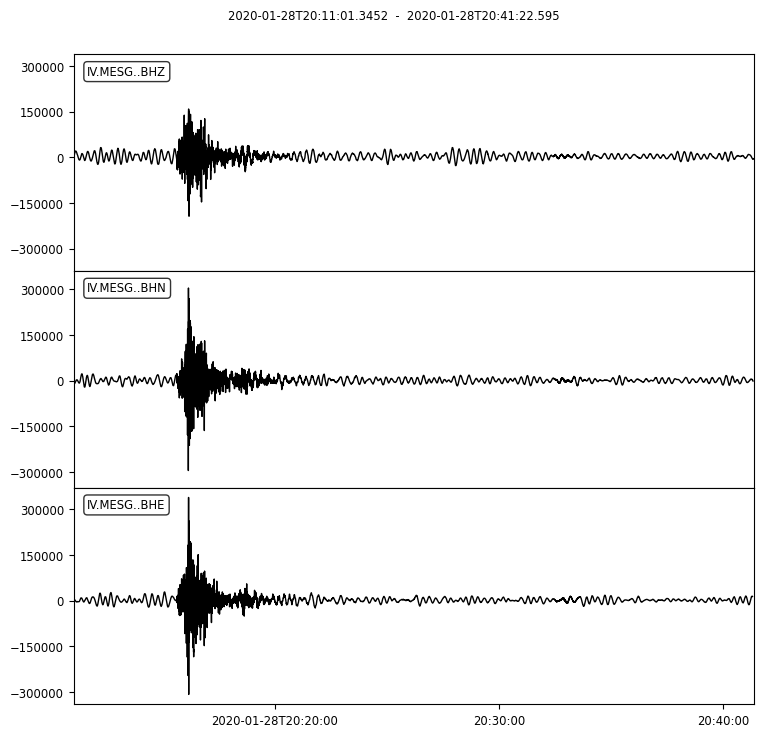

In [50]:
for station in validated_stations:
    stationArrivalTime = getPArrival(event, station)
    st = CLIENT_EIDA.get_waveforms(
        network=station["network"],
        station=station["station"],
        channel=station["channels"],
        starttime=(stationArrivalTime - 600).isoformat(),
        endtime=(stationArrivalTime + 1200).isoformat(),
    )
    print(st)
    st.plot()
    # Break after first station for better readibility
    break